<!-- :Author: Arthur Goldberg <Arthur.Goldberg@mssm.edu> -->
<!-- :Date: 2020-07-13 -->
<!-- :Copyright: 2020, Karr Lab -->
<!-- :License: MIT -->

# A stochastic epidemic model

Epidemics occur when infectious diseases spread through a susceptible population.
Models that classify individuals by their infectious state are widely used to analyze and predict the dynamics of epidemics.
A well-known and simple approach considers these three infectious states:

* *Susceptible*: an individual who can become infected if exposed
* *Infectious*: an individual who is infected, and can transmit the infection to a person who is susceptible
* *Recovered*: an individual who has recovered from an infection, and is not susceptible to being reinfected

Dynamic analyses of spreading infection that employ these states are called Susceptible, Infectious, or Recovered (SIR) epidemic models.
SIR models are characterized by the initial population of individuals in each state and the rates at which individuals transition between states.

![SIR model states and transitions](figures/SIR_Flow_Diagram.svg)
<i><center>SIR model states and transitions</center></i>

In this figure, the transitions between states are labeled with the standard SIR transition rates, in individuals per unit time.
*S* and *I* represent the number of individuals in states Susceptible and Infectious, respectively, *N* is the total number of individauls, and &beta; and &gamma; are model parameters, with units of 1/day.

We present a stochastic SIR model that demonstrates core features of DE-Sim.
Epidemics must be modelled stochastically when the number of infectious individuals is small or when variability in the rates of transitions between model states influences an epidemic's trajectory.

The SIR model below uses DE-Sim to implement a continuous-time Markov chain model, as described in section 3 of Allen (2017).
See Allen (2017) for a mathematical derivation of the approach.

Let's implement and use a SIR model.
First, use `pip` to install `de_sim`.

In [1]:
import de_sim

We will create a SIR model that represents every transition of an individual between states as a discrete event.
The model will iterate over many events.

First, let's represent the state of a SIR model. A `SIR` object stores the number of individuals in the S and I states, and the total number of individuals. It also stores the rate constants for transitions. a SIR object is initialized with the initial state of the epidemic.
It also stores a random number generator, which will be used to obtain stochastic samples.

In [2]:
import numpy

class SIR(object):
    """ Implement a Susceptible, Infectious, or Recovered (SIR) epidemic model

    Attributes:
        s (`int`): number of susceptible individuals
        i (`int`): number of infectious individuals
        N (`int`): total number of individuals, a constant
        beta (`float`): SIR beta parameter, in 1/day units
        gamma (`float`): SIR gamma parameter, in 1/day units
    """
    def __init__(self, s, i, N, beta, gamma):
        """ Initialize a SIR instance

        Args:
            s (`int`): initial number of susceptible individuals, s(0)
            i (`int`): initial number of infectious individuals, i(0)
            N (`int`): total number of individuals, a constant
            beta (`float`): SIR beta parameter
            gamma (`float`): SIR gamma parameter
        """
        self.s = s
        self.i = i
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.random_state = numpy.random.RandomState()

## Overview

The SIR model iterates over a sequence of events that occur at discrete times. Each iteration does the following:
1. receive an event
2. execute the transition encoded in the event message
3. plan the next transition
4. schedule the next event

Next, we create the logic for handling transitions in steps 2 and 3. Below we add code to run steps 1 and 4.

The transitions can be encoded in an emum:

In [3]:
import enum

class StateTransitionType(enum.Enum):
    " State transition types "
    s_to_i = 'Transition from Susceptible to Infectious'
    i_to_r = 'Transition from Infectious to Recovered'

This `SIR` method simply transitions one individual between states.

In [4]:
def handle_state_transition(self, transition_type):
    """ Handle an infectious state transition

    Args:
        transition_type (`StateTransitionType`): a transition type
    """
    if transition_type is StateTransitionType.s_to_i:
        # move an individual from state s to state i
        self.s -= 1
        self.i += 1
    elif transition_type is StateTransitionType.i_to_r:
        self.i -= 1

# We add this method to SIR
setattr(SIR, 'handle_state_transition', handle_state_transition)

## Event messages

Each simulation event carries a `DE-Sim` `EventMessage` that describes the event's action.
An event is executed at a discrete simulation time specified when the event is scheduled (sent).

Next we define `TransitionMessage`, an `EventMessage` subclass that indicates which transition should occur.
The attribute, `transition_type`, will store a `StateTransitionType` instance.

[`EventMessage`](https://docs.karrlab.org/de_sim/master/source/de_sim.html#de_sim.event_message.EventMessage) supports declarative definition of subclasses that automatically define their variables.
Like Python [Data Classes](https://docs.python.org/3/library/dataclasses.html), `EventMessage`s are defined using [PEP 526](https://www.python.org/dev/peps/pep-0526) type annotations.
An event message class should be documented by a docstring, as illustrated.

In [5]:
class TransitionMessage(de_sim.EventMessage):
    "Message for all model transitions"
    transition_type: StateTransitionType

Next we create a `SIR` method that plans the next transition. `rates` contains the rates of the two possible transitions. If both rates are 0 then `lambda_val == 0`, no transitions will occur, and `None` is returned.
Otherwise, the delay until the next event is sampled from an exponential distribution.
A uniform random sample is used weigh the transition type probabilities according to their relative rates.
The tuple returned will be used to schedule the next event.

In [6]:
def plan_next_transition(self):
    """ Schedule the next SIR event.

    Returns:
        :obj:`tuple`: a pair (the delay to the event, the event's message if an event is
            scheduled, otherwise :obj:`None`
    """
    rates = {'s_to_i': self.beta * self.s * self.i / self.N,
             'i_to_r': self.gamma * self.i}
    lambda_val = rates['s_to_i'] + rates['i_to_r']
    if lambda_val == 0:
        return

    tau = self.random_state.exponential(1.0/lambda_val)
    prob_s_to_i = rates['s_to_i'] / lambda_val
    if self.random_state.random_sample() < prob_s_to_i:
        return (tau, TransitionMessage(StateTransitionType.s_to_i))
    else:
        return (tau, TransitionMessage(StateTransitionType.i_to_r))

# Add this method to SIR
setattr(SIR, 'plan_next_transition', plan_next_transition)

## Simulation objects

Next we create and schedule events, and receive and execute them -- steps 1 and 4 in the iteration loop in the Overview.

We'll use `DE-Sim`'s features by subclassing [`SimulationObject`](https://docs.karrlab.org/de_sim/master/source/de_sim.html#de_sim.simulation_object.SimulationObject), and obtain SIR logic by composing a `SIR` instance.

In [7]:
class SIRSimulator(de_sim.SimulationObject):

    def __init__(self, name, s, i, N, beta, gamma):
        self.sir = SIR(s, i, N, beta, gamma)
        super().__init__(name)

    def handle_event(self, event):
        """ Handle an event.

        Args:
            event (`de_sim.Event`): simulation event that contains an event message
        """
        self.sir.handle_state_transition(event.message.transition_type)
        self.plan_and_create_event()

    def plan_and_create_event(self):
        " Plan and create the next event. "
        planned_event = self.sir.plan_next_transition()
        if planned_event is not None:
            self.schedule_next_event(planned_event)

    def schedule_next_event(self, planned_event):
        tau, transition_message = planned_event
        self.send_event(tau, self, transition_message)

    def init_before_run(self):
        " Initialize before a simulation run. Send the first event. "
        self.plan_and_create_event()

    event_handlers = [(TransitionMessage, 'handle_event')]

    # register the message types sent
    messages_sent = [TransitionMessage]

`SIRSimulator` completes the functionality of an iteration. Referencing the steps in the Overview, we explain how it works:

1. *receive an event*: `handle_event` is called by DE Sim's simulator when `SIRSimulator` receives an event. It's an upcall by the simulator which is reported to the simulator by the attribute `event_handlers`, which associates each [`EventMessage`](https://docs.karrlab.org/de_sim/master/source/de_sim.html#de_sim.event_message.EventMessage) subclass with the method that handles events containing the class.
2. *execute the transition encoded in the event message*: `SIR`'s `handle_state_transition` method does this.
3. *plan the next transition*: `plan_and_create_event` uses `SIR.plan_next_transition()` to do  this.
4. *schedule the next event*: `schedule_next_event` uses the delay and event message of a planned event, and the method `send_event` provided by `SimulationObject` to schedule the new event `tau` days in the future.

`init_before_run` is an optional special method which `SimulationObject`s can use for initialization.
Just before a simulation starts, the simulator calls all `init_before_run` methods.
Here, it sends the first event.

## Checkpointing

Checkpointing periodically saves a simulation's state so that its history is available for analysis later.
A simulation's state is conceptualized as a set of values, and the state of its random number generator.
A checkpointing object, an instance of DE-Sim's `CheckpointSimulationObject`, will periodically checkpoint the simulation's state.
It must be given an object that complies with the interface defined in `AccessStateObjectInterface`, which implements methods that return the simulation's state (`get_checkpoint_state`) and random number generator state (`get_random_state`), as shown in `AccessSIRObjectState` below.

In [8]:
from de_sim.checkpoint import AccessCheckpoints, Checkpoint
from de_sim.simulation_checkpoint_object import (AccessStateObjectInterface,
                                                 CheckpointSimulationObject)

class AccessSIRObjectState(AccessStateObjectInterface):
    """ Get the state of a SIR object

    Attributes:
        sir (`obj`): a SIR object
        random_state (`numpy.random.RandomState`): a random state
    """
    def __init__(self, sir):
        self.sir = sir
        self.random_state = sir.random_state

    def get_checkpoint_state(self, time):
        """ Get the SIR simulation's state

        Args:
            time (`float`): current time; ignored
        """
        return dict(s=self.sir.s,
                    i=self.sir.i)

    def get_random_state(self):
        """ Get the SIR object's random state
        """
        return self.random_state.get_state()

## Running a simulation

The next cell defines code to run the SIR model and visualize its predictions.
An instance of `CheckpointSimulationObject` is added to the simulation. It needs a name, its checkpointing period, a directory in which to save checkpoints, and an object that can access the simulation's state, like `AccessSIRObjectState` above.
The `AccessCheckpoints` class obtains checkpoint data from the directory storing them.

In [9]:
import pandas

class RunSIR(object):

    def __init__(self, checkpoint_dir):
        self.checkpoint_dir = checkpoint_dir

    def simulate(self, recording_period, max_time, **sir_args):
        """ Create and run a SIR simulation

        Args:
            recording_period (`float`): interval between state checkpoints
            max_time (`float`): simulation end time
            sir_args (`dict`): arguments for a SIR object
        """
        # create a simulator
        simulator = de_sim.Simulator()

        # create a SIRSimulator instance
        self.sir_simulator = SIRSimulator(**sir_args)
        simulator.add_object(self.sir_simulator)

        # create a checkpoint simulation object
        access_state_object = AccessSIRObjectState(self.sir_simulator.sir)
        checkpointing_obj = CheckpointSimulationObject('checkpointing_obj',
                                                       recording_period,
                                                       self.checkpoint_dir,
                                                       access_state_object)
        simulator.add_object(checkpointing_obj)

        # initialize simulation, which sends the SIR instance an initial event message
        simulator.initialize()

        # run the simulation
        event_num = simulator.simulate(max_time).num_events

    def last_checkpoint(self):
        """ Get the last checkpoint of the last simulation run

        Returns:
            `Checkpoint`: the last checkpoint of the last simulation run
        """
        access_checkpoints = AccessCheckpoints(self.checkpoint_dir)
        last_checkpoint_time = access_checkpoints.list_checkpoints()[-1]
        return access_checkpoints.get_checkpoint(time=last_checkpoint_time)

    def history_to_dataframe(self):
        """ Convert the checkpoint history to a Pandas dataframe

        Returns:
            `pandas.DataFrame`: SIR values are columns, rows are timepoints
        """
        fields = ('s', 'i', 'r')
        hist = []
        index = []
        access_checkpoints = AccessCheckpoints(self.checkpoint_dir)
        for checkpoint_time in access_checkpoints.list_checkpoints():
            state = access_checkpoints.get_checkpoint(time=checkpoint_time).state
            state_as_list = [state['s'], state['i'],
                             self.sir_simulator.sir.N - state['s'] - state['i']]
            hist.append(dict(zip(fields, state_as_list)))
            index.append(checkpoint_time)
        return pandas.DataFrame(hist)

Let's use the model to view an epidemic's predictions.
We use parameters from Allen (2017), and print and plot the trajectory of a 4 simulation runs.
Since the model is stochastic, each run produces a different trajectory.

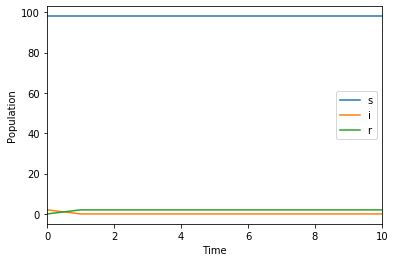

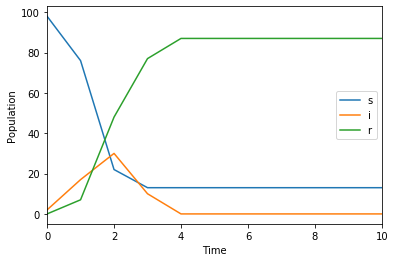

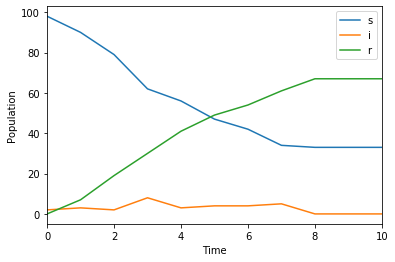

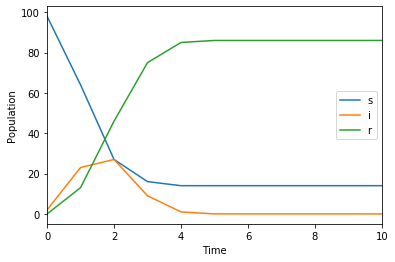

In [10]:
import tempfile

sir_args = dict(name='sir',
                s=98,
                i=2,
                N=100,
                beta=0.3,
                gamma=0.15)
with tempfile.TemporaryDirectory() as tmpdirname:
    for _ in range(4):
        run_sir = RunSIR(tmpdirname)
        run_sir.simulate(10, 100, **sir_args)

        # print and plot an epidemic's predicted trajectory
        sir_data_frame = run_sir.history_to_dataframe()
        axes = sir_data_frame.plot()
        axes.set_xlabel("Time")
        rv = axes.set_ylabel("Population")

## Evaluate an epidemic's severity
An important prediction generated by the SIR model is the severity of the epidemic, which can be summarized by the fraction of people who became infected. We run an ensemble of simulations and examine the predicted distribution of severity.

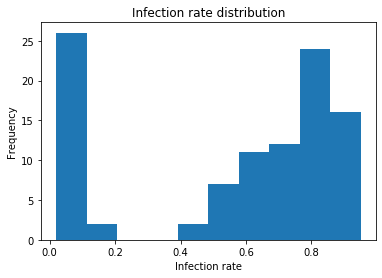

In [11]:
import math

num_sims = 100
infection_rates= []

for _ in range(num_sims):
    with tempfile.TemporaryDirectory() as tmpdirname:
        run_sirs = RunSIR(tmpdirname)
        run_sirs.simulate(recording_period=10, max_time=60, **sir_args)
        # infection rate = infectious + recovered
        # N = s + i + r => i + r = N - s
        final_state = run_sirs.last_checkpoint().state
        N = sir_args['N']
        infection_rate = (N - final_state['s'])/N
        infection_rates.append(infection_rate)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
rv = plt.hist(infection_rates)
ax.set_title('Infection rate distribution')
ax.set_xlabel('Infection rate')
rv = ax.set_ylabel('Frequency')

As predicted by Allen's (2017) analysis, for the parameters in `sir_args` the infection rate distribution is bimodal. Most of the epidemics infect a majority of the population while a small fraction of them (Allen predicts 25%) burn out and infect only a minority of the population.

The simple model above only touches the surface of epidemic modeling. Many extensions are possible:

* A spatial model with multiple geographic areas: each area would be represented by an instance of SIR.
* An extension of the spatial model that also represents travel between geographic areas.
* A model that represents individuals in more states, such as multiple infectious states which distinguish between asymptomatic and symptomatic individuals, with a lower transmission parameter β for symptomatic individuals who would likely isolate while recovering.
* A model that can model both small and large populations: it would use the stochastic approach above to integrate small populations and ODEs to integrate large populations. Models and simulators that use multiple integration methods are called multi-algorithmic.

We encourage you to experiment with different parameters for this model and build your own models!

## Conclusion

We've shown a complete DE-Sim simulation of a SIR epidemic model.
For pedagogical purposes we broke the code into many pieces. A real implementation should be made more consise by combining the classes `SIR` and `SIRSimulator`.

Other discrete-event models can be written in DE-Sim by following the same recipie:

- Define one or more [`SimulationObject`](https://docs.karrlab.org/de_sim/master/source/de_sim.html#de_sim.simulation_object.SimulationObject) classes that store state, and schedule events for themselves and/or each other.
- Create a [`Simulator`](https://docs.karrlab.org/de_sim/master/source/de_sim.html#de_sim.simulator.Simulator).
- Create initial conditions and instantiate one or more instances of each `SimulationObject` class to stimulate the model.
- Add a checkpointing class to save each run's trajectory.
- Visualize and analyze a set of simulation runs.

Happy modeling!

## References

Allen, L.J., 2017. A primer on stochastic epidemic models: Formulation, numerical
simulation, and analysis. Infectious Disease Modelling, 2(2), pp.128-142.